In [1]:
import os
import warnings
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [2]:
import numpy as np
import torch

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


In [4]:
df_dataset = pd.read_csv('../../../../data/amazonreview_reduced_bert_train_sentence.csv')


In [5]:
df_dataset

,class,sentence,sentence_embedding
0,1,this one seemed inappropriate,[-7.07429171e-01 -9.20562893e-02 5.68922281e-...
1,1,Its Time Has Passed,[-0.93544328 -0.35473078 -0.44945127 0.866203...
2,1,This documentary is offensive,[-8.98015499e-01 -3.35524023e-01 5.96269146e-...
3,2,this one was ok,[-7.29380667e-01 -1.04420066e-01 7.20309854e-...
4,2,The lyrics are incredible,[-8.35999787e-01 -2.15908080e-01 1.77436873e-...
...,...,...,...
3495,1,3 copies malfunctioned,[-0.87984288 -0.41457954 -0.77102768 0.650709...
3496,1,power button broke,[-8.55285764e-01 -2.75634378e-01 1.59563810e-...
3497,2,GI JOE ROCKS,[-8.90328825e-01 -3.98124784e-01 -6.46599770e-...
3498,2,Storm Trooper Rocks,[-8.48008156e-01 -3.06839705e-01 -1.60301134e-...


In [6]:
def preprocess_dataset(csv_file):
    """
    Preprocess function for the dataset + Create train/test split
    """
    df_dataset = pd.read_csv(csv_file)

    df_dataset['sentence_embedding'] = np.array([np.fromstring(embedding.strip(' []'), sep=' ') for embedding in df_dataset['sentence_embedding']]).tolist()

    #Preprocess labels
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(df_dataset['class'])
    df_dataset['class'] = label_encoder.transform(df_dataset['class'])

    X_train, X_test, y_train, y_test = train_test_split(df_dataset[['sentence_embedding', 'sentence']], df_dataset['class'], test_size=0.2)

    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = preprocess_dataset('../../../../data/amazonreview_reduced_bert_train_sentence.csv')

In [8]:
#For testing purposes
#X_train = X_train[0:400]
#y_train = y_train[0:400]
#X_test = X_test[0:100]
#y_test = y_test[0:100]

In [9]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')

raw_train_diagrams = parser.sentences2diagrams(X_train['sentence'].values.tolist(), suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(X_test['sentence'].values.tolist(), suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [10]:
from lambeq import Rewriter
# Apply rewrite rule for prepositional phrases

rewriter = Rewriter(['prepositional_phrase', 'determiner', 'curry'])

raw_train_diagrams = [rewriter(diagram) for diagram in raw_train_diagrams]
raw_val_diagrams = [rewriter(diagram) for diagram in raw_val_diagrams]

In [11]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, y_train)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, y_test)
    if diagram is not None
]

In [659]:
train_diagrams.__len__()

2800

In [660]:
from lambeq import AtomicType, IQPAnsatz, remove_cups

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=4, n_single_qubit_params=3)

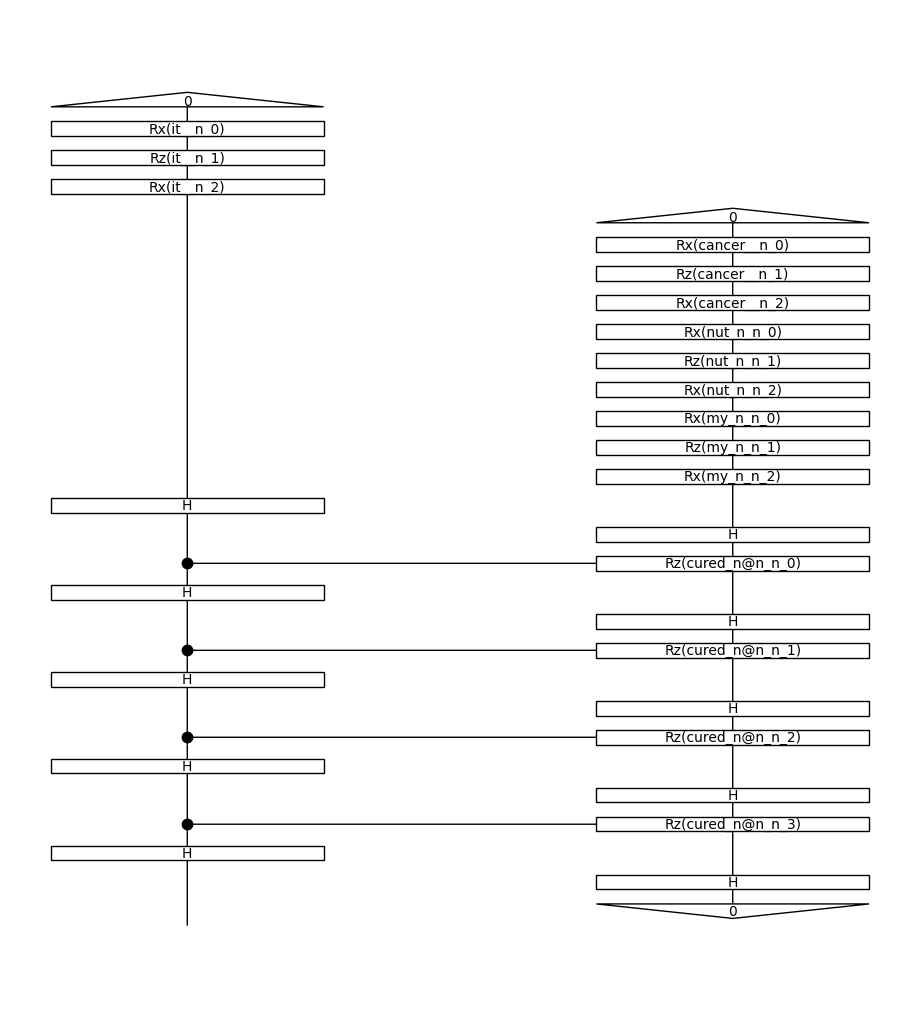

In [665]:
train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

train_circuits[0].draw(figsize=(9, 10))

## Hybrid QNLP Model

In [666]:
BATCH_SIZE = 2048
EPOCHS = 50
SEED = 2
LR = 5e-2
GAMMA_LR = 0.5    # Learning rate reduction applied every STEP_LR epochs.
STEP_LR = 20

In [667]:
from torch import nn
from lambeq import PennyLaneModel

# inherit from PennyLaneModel to use the PennyLane circuit evaluation
class DressedQuantumModel(PennyLaneModel):
    def __init__(self, **kwargs):
        PennyLaneModel.__init__(self, **kwargs)

        self.pre_qc = nn.Sequential(nn.Linear(768, len(self.weights)),
                                    nn.LeakyReLU(0.01))

        #self.post_qc = nn.Sequential(nn.Linear(2, 10),
        #                             nn.LeakyReLU(0.01),
        #                             nn.Linear(10, 1),
        #                             nn.Sigmoid())
        
        self.post_qc = nn.Sequential(nn.Linear(2, 1),
                                nn.Sigmoid())


    def forward(self, diagram, embedding):
        # pass the embedding through a simple neural network
        embedding_out = self.pre_qc(embedding)
        self.weights = torch.nn.ParameterList(
            [torch.nn.Parameter(emb)
             for emb in embedding_out]
        )

        diagram = self.get_diagram_output(diagram)
        
        # pass the concatenated results through a simple neural network
        return self.post_qc(diagram)
    

In [668]:
all_circuits = train_circuits + val_circuits

In [670]:
from lambeq import Dataset

# initialise datasets and optimizers as in PyTorch
train_dataset = Dataset(list(zip(train_circuits, np.vstack(X_train['sentence_embedding'].apply(np.array)))),
                        train_labels,
                        batch_size=BATCH_SIZE)

valid_dataset = Dataset(list(zip(val_circuits, np.vstack(X_test['sentence_embedding'].apply(np.array)))),
                        val_labels,
                        batch_size=BATCH_SIZE)


In [671]:
model = DressedQuantumModel.from_diagrams(all_circuits, probabilities=True, normalize=True)
# initialise our model by passing in the diagrams, so that we have trainable parameters for each token
model.initialise_weights()
model = model.double()

In [677]:
def accuracy(circuits, embeddings, labels):
    predicted = model(circuits, torch.from_numpy(np.vstack(embeddings)))
    return (torch.round(torch.flatten(predicted)) ==
            torch.DoubleTensor(labels)).sum().item()/len(circuits)

In [678]:
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-2)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer, step_size=STEP_LR, gamma=GAMMA_LR
)

In [679]:
from torch.utils.tensorboard import SummaryWriter
import datetime

log_dir = "logs/fit_pennylane_lambeq/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = SummaryWriter(log_dir=log_dir)

In [680]:
best = {'acc': 0, 'epoch': 0}
best_val_loss = 1000
best_val_acc = 0
best_train_loss = 1000
best_acc_train = 0

for epoch in range(EPOCHS):
    print('Epoch: {}'.format(epoch))
    running_loss = 0.0
    running_corrects = 0

    #for circuits, embeddings, labels in train_dataloader:
    for input, labels in train_dataset:
        batch_size_ = len(input)
        circuits, embeddings = np.array(input).T
        optimizer.zero_grad()
        predicted = model(circuits, torch.from_numpy(np.vstack(embeddings)))

        # use BCELoss as our outputs are probabilities, and labels are binary
        loss = criterion(torch.flatten(predicted), torch.DoubleTensor(labels))
        #running_loss += loss.item()
        running_loss += loss.item()*batch_size_
        loss.backward()
        optimizer.step()

        batch_corrects = (torch.round(torch.flatten(predicted)) == torch.DoubleTensor(labels)).sum().item()
        running_corrects += batch_corrects
        


    # Print epoch results
    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects / len(train_dataset)
    

    summary_writer.add_scalar("Training/Loss", train_loss, epoch)
    summary_writer.add_scalar("Training/Acurracy", train_acc, epoch)

    if train_loss < best_train_loss:
        best_train_loss = train_loss

    if train_acc > best_acc_train:
        best_acc_train = train_acc

    running_loss = 0.0
    running_corrects = 0

    # evaluate on valid set every 5 epochs
    # save the model if it's the best so far
    # stop training if the model hasn't improved for 10 epochs
    for input, labels in valid_dataset:
        batch_size_ = len(input)
        circuits, embeddings = np.array(input).T
        optimizer.zero_grad()
        predicted = model(circuits, torch.from_numpy(np.vstack(embeddings)))

        loss = criterion(torch.flatten(predicted), torch.DoubleTensor(labels))
        running_loss += loss.item()*batch_size_


        batch_corrects = (torch.round(torch.flatten(predicted)) == torch.DoubleTensor(labels)).sum().item()
        running_corrects += batch_corrects


    validation_loss = running_loss / len(valid_dataset)
    validation_acc = running_corrects / len(valid_dataset)

    summary_writer.add_scalar("Validation/Loss", validation_loss, epoch)
    summary_writer.add_scalar("Validation/Acurracy", validation_acc, epoch)

    exp_lr_scheduler.step()
    
    print('Train loss: {}'.format(train_loss))
    print('Valid loss: {}'.format(train_acc))
    print('Train acc: {}'.format(validation_loss))
    print('Valid acc: {}'.format(validation_acc))

    if validation_acc > best_val_acc:
            best_val_acc = validation_acc
            best['epoch'] = epoch
            model.save('nlp_dressed_alpha_model.lt')
    #elif epoch - best['epoch'] >= 10:
    #    print('Early stopping')
    #    break


    if validation_loss < best_val_loss:
        best_val_loss = validation_loss




# load the best performing iteration of the model on the dev set
#if best['acc'] > accuracy(train_circuits, train_labels):
#    model.load('xor_model.lt')
#    model = model.double()

Epoch: 0
Train loss: 0.7611944997683185
Valid loss: 0.48142857142857143
Train acc: 0.7326724149642876
Valid acc: 0.48142857142857143
Epoch: 1
Train loss: 0.7303694960820161
Valid loss: 0.48142857142857143
Train acc: 0.7098803564538135
Valid acc: 0.48142857142857143
Epoch: 2
Train loss: 0.7082897163573614
Valid loss: 0.48142857142857143
Train acc: 0.6971199492884111
Valid acc: 0.48142857142857143
Epoch: 3
Train loss: 0.6958831819759907
Valid loss: 0.47964285714285715
Train acc: 0.6926131265283955
Valid acc: 0.5285714285714286
Epoch: 4
Train loss: 0.6927510003065529
Valid loss: 0.5192857142857142
Train acc: 0.6940785949435067
Valid acc: 0.5185714285714286
Epoch: 5
Train loss: 0.6943316829954583
Valid loss: 0.5185714285714286
Train acc: 0.6969487291164322
Valid acc: 0.5185714285714286
Epoch: 6
Train loss: 0.6971085342971455
Valid loss: 0.5185714285714286
Train acc: 0.6995450155633771
Valid acc: 0.5185714285714286
Epoch: 7
Train loss: 0.6996373667669471
Valid loss: 0.5185714285714286
Train

In [681]:
summary_writer.add_hparams({'lr': LR, 'gamma_lr': GAMMA_LR, 'step_lr': STEP_LR},
                      {'hparam/loss_train': best_train_loss, 'hparam/acc_train': best_acc_train,
                       'hparam/loss_valid': best_val_loss, 'hparam/acc_valid': best_val_acc})